In [1]:
%reset -s -f

In [2]:
import os
from functools import partial

import numpy as np
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch 
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI
from pyro.infer import Trace_ELBO
from pyro.infer import Predictive

In [3]:
%matplotlib inline

In [4]:
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)
pyro.set_rng_seed(42)
pyro.enable_validation(True)


### Generate a set of randomly distributed features

In [5]:
y = normal(0.7, 0.2, 1000)

In [6]:
# lets create an artificial dataset from randomly sampled points
data_df = pd.DataFrame({"F1": binomial(1, 0.1, 1000), 
                       "F2": binomial(1, 0.2, 1000),
                        "F3": binomial(1, 0.1, 1000),
                       "F4": binomial(1, 0.3, 1000), 
                       "F5": binomial(1, 0.5, 1000),
                       "F6": binomial(1, 0.2, 1000), 
                       "F7": binomial(1, 0.3, 1000),
                       "F8": binomial(1, 0.5, 1000),
                       "F9": binomial(1, 0.1, 1000),
                       "F10": binomial(1, 0.1, 1000),
                       "EXPLAIN": y})
data_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,EXPLAIN
0,0,0,0,0,0,0,0,1,0,0,0.799343
1,0,0,0,0,1,0,0,1,0,0,0.672347
2,0,0,0,0,0,0,0,0,1,0,0.829538
3,0,0,0,0,0,0,0,1,0,0,1.004606
4,0,1,0,0,1,0,0,1,0,1,0.653169
...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,1,0,0,0.643780
996,0,0,0,0,1,0,0,1,0,0,1.059537
997,0,0,1,0,0,0,0,1,0,0,0.828169
998,0,1,0,1,1,0,1,1,0,0,0.585764


In [7]:
# make categorical data plottable
melted_df = pd.melt(data_df, id_vars="EXPLAIN")
melted_df = melted_df[melted_df["value"] != 0][["EXPLAIN", "variable"]]

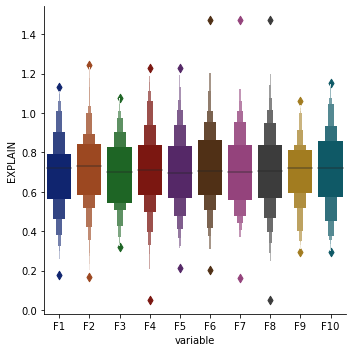

In [8]:
sns.catplot(x="variable", y="EXPLAIN", kind="boxen", palette="dark",
            data=melted_df)

In [9]:
# make the data PyTorch objects
X = torch.tensor(data_df[["F{}".format(i+1) for i in range(10)]].values, dtype=torch.float)
y = torch.tensor(data_df.EXPLAIN.values, dtype=torch.float)

INPUT_DIM = 10
OUTPUT_DIM = 1
ITERATIONS = 1500

X

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

In [10]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0.,1.)
                                         .expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.)
                                      .expand([out_features]).to_event(1))
    
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [11]:
# instantiate leaerning objects
bayes_reg_model = BayesianRegression(INPUT_DIM, OUTPUT_DIM)
guide = AutoDiagonalNormal(bayes_reg_model)

adam_opt = pyro.optim.Adam({"lr": 0.03})
svi = SVI(bayes_reg_model, guide, adam_opt, loss=Trace_ELBO())

In [12]:
pyro.clear_param_store()
for i in range(ITERATIONS):
    # make inference step
    loss = svi.step(X, y)
    # observe testing
    if i % 100 == 0:
        print("[iteration {}] loss: {}".format(i, loss / len(X)))

[iteration 0] loss: 3.278953137278557
[iteration 100] loss: 1.8395739648342133
[iteration 200] loss: -0.10384397792816162
[iteration 300] loss: -0.15536775732040406
[iteration 400] loss: -0.15713858342170714
[iteration 500] loss: -0.1551352195739746
[iteration 600] loss: -0.14897570419311523
[iteration 700] loss: -0.15510943937301636
[iteration 800] loss: -0.1568317747116089
[iteration 900] loss: -0.14908217906951904
[iteration 1000] loss: -0.16141310334205627
[iteration 1100] loss: -0.15414558887481689
[iteration 1200] loss: -0.15185554146766664
[iteration 1300] loss: -0.15520715045928954
[iteration 1400] loss: -0.15263343834877013


In [13]:
# inspect learned parameters
guide.requires_grad_(False)
print("Learned parameters:")
for name, param in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
print("Guide parameters:")
print(guide.quantiles([0.25, 0.5, 0.75]))

Learned parameters:
AutoDiagonalNormal.loc Parameter containing:
tensor([-3.9151e+00, -1.1454e-02,  1.1648e-02, -2.2069e-02,  2.4282e-02,
         2.9107e-03,  3.6307e-02,  1.0355e-03, -4.7750e-03,  3.8911e-03,
         1.0372e-03,  6.9383e-01])
AutoDiagonalNormal.scale tensor([0.0214, 0.0165, 0.0160, 0.0222, 0.0116, 0.0088, 0.0125, 0.0114, 0.0081,
        0.0216, 0.0214, 0.0061])
Guide parameters:
{'sigma': [tensor(0.1927), tensor(0.1955), tensor(0.1983)], 'linear.weight': [tensor([[-0.0226,  0.0009, -0.0370,  0.0165, -0.0030,  0.0279, -0.0066, -0.0102,
         -0.0106, -0.0134]]), tensor([[-0.0115,  0.0116, -0.0221,  0.0243,  0.0029,  0.0363,  0.0010, -0.0048,
          0.0039,  0.0010]]), tensor([[-0.0003,  0.0224, -0.0071,  0.0321,  0.0088,  0.0447,  0.0087,  0.0007,
          0.0184,  0.0154]])], 'linear.bias': [tensor([0.6897]), tensor([0.6938]), tensor([0.6979])]}


In [14]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v,0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


In [15]:
predict = Predictive(bayes_reg_model, guide=guide, num_samples=800,
                    return_sites=("linear.weight", "obs", "_RETURN"))
samples = predict(X)
pred_summary = summary(samples)

In [16]:
mu = pred_summary["_RETURN"]
y_hat = pred_summary["obs"]
predictions = pd.DataFrame({
    "F1": data_df.F1,
    "F2": data_df.F2,
    "F3": data_df.F3,
    "F4": data_df.F4,
    "F5": data_df.F5,
    "F6": data_df.F6,
    "F7": data_df.F7,
    "F8": data_df.F8,
    "F9": data_df.F9,
    "F10": data_df.F10,
    "mu_mean": mu["mean"],
    "mu_p95": mu["95%"],
    "mu_p5": mu["5%"],
    "y_mean": y_hat["mean"],
    "y_p95": y_hat["95%"],
    "y_p5": y_hat["5%"],
    "Y": y,
})
predictions

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,mu_mean,mu_p95,mu_p5,y_mean,y_p95,y_p5,Y
0,0,0,0,0,0,0,0,1,0,0,0.690068,0.707027,0.673036,0.684909,1.002709,0.382020,0.799343
1,0,0,0,0,1,0,0,1,0,0,0.692584,0.714328,0.669887,0.681588,1.007880,0.364762,0.672347
2,0,0,0,0,0,0,0,0,1,0,0.697690,0.733249,0.661211,0.697982,1.000050,0.390381,0.829538
3,0,0,0,0,0,0,0,1,0,0,0.690068,0.707027,0.673036,0.695463,0.998649,0.391991,1.004606
4,0,1,0,0,1,0,0,1,0,1,0.705946,0.752596,0.659359,0.718946,1.056015,0.386416,0.653169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,1,0,0,0.700848,0.732471,0.670753,0.706360,1.036105,0.386660,0.643780
996,0,0,0,0,1,0,0,1,0,0,0.692584,0.714328,0.669887,0.697407,1.022373,0.377828,1.059537
997,0,0,1,0,0,0,0,1,0,0,0.667512,0.707727,0.627507,0.664679,0.971336,0.349156,0.828169
998,0,1,0,1,1,0,1,1,0,0,0.729266,0.771362,0.686690,0.736550,1.068425,0.394582,0.585764


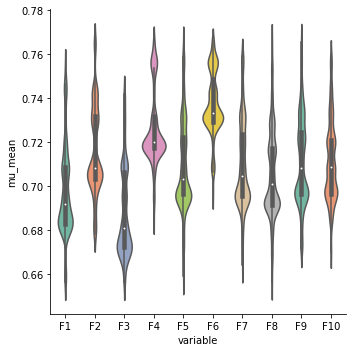

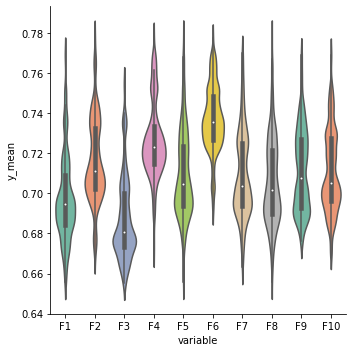

In [17]:
melted_pred = pd.melt(predictions, id_vars=["mu_mean", "y_mean", "Y"], 
        value_vars=["F{}".format(i+1) for i in range(10)])
melted_mu_pred_df = melted_pred[melted_pred["value"] != 0][["mu_mean", "variable"]]
melted_y_pred_df = melted_pred[melted_pred["value"] != 0][["y_mean", "variable"]]

sns.catplot(x="variable", y="mu_mean", kind="violin", bw=.2, palette="Set2", data=melted_mu_pred_df)
sns.catplot(x="variable", y="y_mean", kind="violin", bw=.2, palette="Set2", data=melted_y_pred_df)

Text(0.5, 0.98, 'Density of Fit')

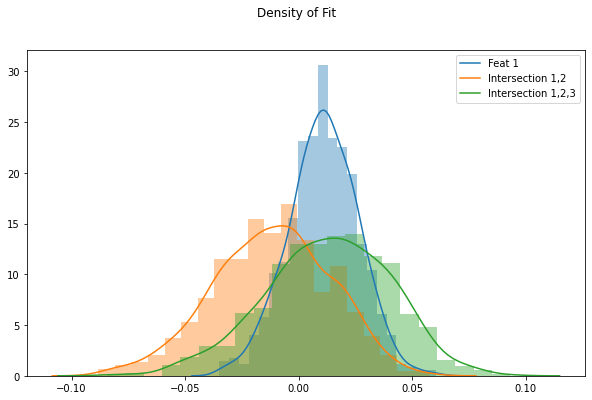

In [23]:
# plot uncertainty
weights = samples["linear.weight"]
weights = weights.reshape(weights.shape[0], 10)
gamma_1 = weights[:, 1]
gamma_12 = weights[:,1] + weights[:, 2]
gamma_123 = weights[:,1] + weights[:, 2] + weights[:, 3]

fig = plt.figure(figsize=(10,6))
sns.distplot(gamma_1, kde_kws={"label": "Feat 1"})
sns.distplot(gamma_12, kde_kws={"label": "Intersection 1,2"})
sns.distplot(gamma_123, kde_kws={"label": "Intersection 1,2,3"})
fig.suptitle("Density of Fit")